### Install Required packages used for Deep Learning LSTM model

In [1]:
## pip install tensorflow
## pip install pandas_datareader

### Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

### Load the Bitcoin USD Data from "Yahoo Finance"

In [3]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2021,1,2)
end = dt.datetime(2022,9,30)

In [4]:
## data from Jan 1, 2021 to Sept 30, 2022

data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',start,end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344
2021-01-02,33155.117188,29091.181641,29376.455078,32127.267578,67865420765,32127.267578
2021-01-03,34608.558594,32052.316406,32129.408203,32782.023438,78665235202,32782.023438
2021-01-04,33440.218750,28722.755859,32810.949219,31971.914062,81163475344,31971.914062
2021-01-05,34437.589844,30221.187500,31977.041016,33992.429688,67547324782,33992.429688
...,...,...,...,...,...,...
2022-09-26,19274.873047,18721.285156,18803.900391,19222.671875,44148798321,19222.671875
2022-09-27,20338.455078,18915.667969,19221.839844,19110.546875,58571439619,19110.546875
2022-09-28,19688.343750,18553.296875,19104.621094,19426.720703,53071298734,19426.720703


### Data Preparation - Data Scaling (Normalization)

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

print(scaled_data[0:5])
print(len(scaled_data))

[[0.22086655]
 [0.27703031]
 [0.29038738]
 [0.27386109]
 [0.31507976]]
638


### Train Test Split

In [6]:
## Train Data (Jan 2021 to Aug 2022) and Test Data (Sept 2022)

prediction_days = 30 ## test data length

## Defining Train data

x_train, y_train = [], []

for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train

print(len(x_train), len(y_train))

608 608


In [7]:
# Defining test data

test_start = dt.datetime(2022,9,2)
test_end = dt.datetime(2022,9,30)

test_data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',test_start,test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)
len(model_inputs)

x_test = []

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test
print(len(x_test))

30


### LSTM Model Building 

In [8]:
# Create Neural Network

model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss = 'mean_squared_error')

## Fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
19/19 [==============================] - 5s 22ms/step - loss: 0.0648
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0189
Epoch 3/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0148
Epoch 4/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0165
Epoch 5/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0129
Epoch 6/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0112
Epoch 7/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0119
Epoch 8/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0107
Epoch 9/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 10/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0101
Epoch 11/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0094
Epoch 12/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0092
Epoch 13/100
19/19 [=====

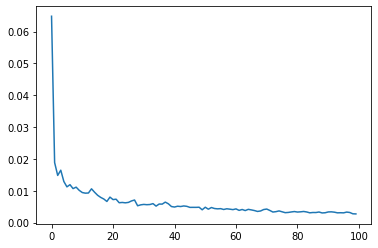

In [9]:
## Ploting loss

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Model Prediction

In [10]:
# Predicting the test data (30 days)

prediction_prices = model.predict(x_test)

# Transforming the predicted data back to actual form

prediction_prices = scaler.inverse_transform(prediction_prices)

1/1 [==============================] - 1s 1s/step


### Actual Test Data vs Predicted Test Data Plot

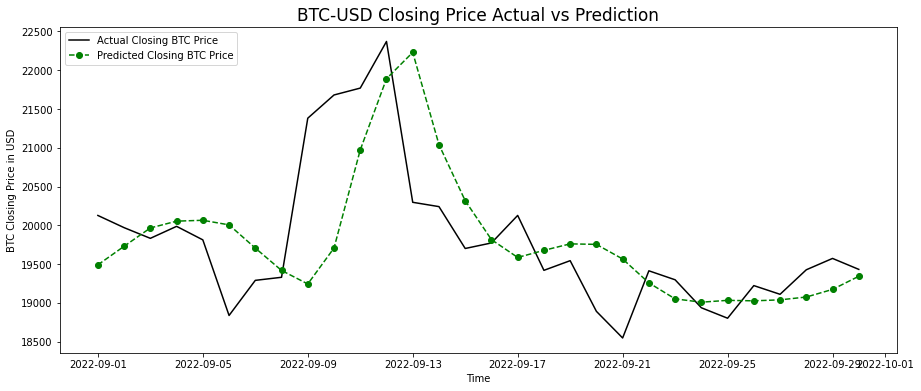

In [21]:
date_range = test_data.index

plt.figure(figsize = (15, 6))
plt.xlabel('Time')
plt.ylabel('BTC Closing Price in USD')
plt.plot(date_range, actual_prices, color = 'black', label = 'Actual Closing BTC Price')
plt.plot(date_range, prediction_prices, color = 'green', marker ='o', linestyle = 'dashed', label = 'Predicted Closing BTC Price')
plt.title('BTC-USD Closing Price Actual vs Prediction', fontsize = 17)
plt.legend(loc = 'upper left')
plt.show()

In [12]:
# Prediction for next day (Oct 1, 2022)

real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs) + 1, 0]]

real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
real_data
len(real_data)

prediction_oct_1 = model.predict(real_data)
prediction_oct_1 = scaler.inverse_transform(prediction_oct_1)
print("Oct 1, 2022 BTC Closing Predicted Price:", prediction_oct_1)

# Prediction value for Sept 30, 2022

pred_30_sept = prediction_prices[-1:]
print("Sept 30, 2022 BTC Closing Predicted Price:", pred_30_sept)

1/1 [==============================] - 1s 1s/step
Oct 1, 2022 BTC Closing Predicted Price: [[19489.791]]
Sept 30, 2022 BTC Closing Predicted Price: [[19342.771]]


### Model Evaluation

In [13]:
## RMSE for 30 days test data (Sept 2022)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_prices,prediction_prices)
rmse = np.sqrt(mse)
print('RMSE for 30 days:', rmse)

RMSE for 30 days: 792.6307141212601


In [14]:
## RMSE for 1 day Sept 30, 2022

actual_30_sept = test_data['Close'][-1:].values

mse = mean_squared_error(actual_30_sept,pred_30_sept)
rmse = np.sqrt(mse)
print('RMSE for 1 day:', rmse)
print(actual_30_sept,pred_30_sept)

RMSE for 1 day: 89.017578125
[19431.7890625] [[19342.771]]
